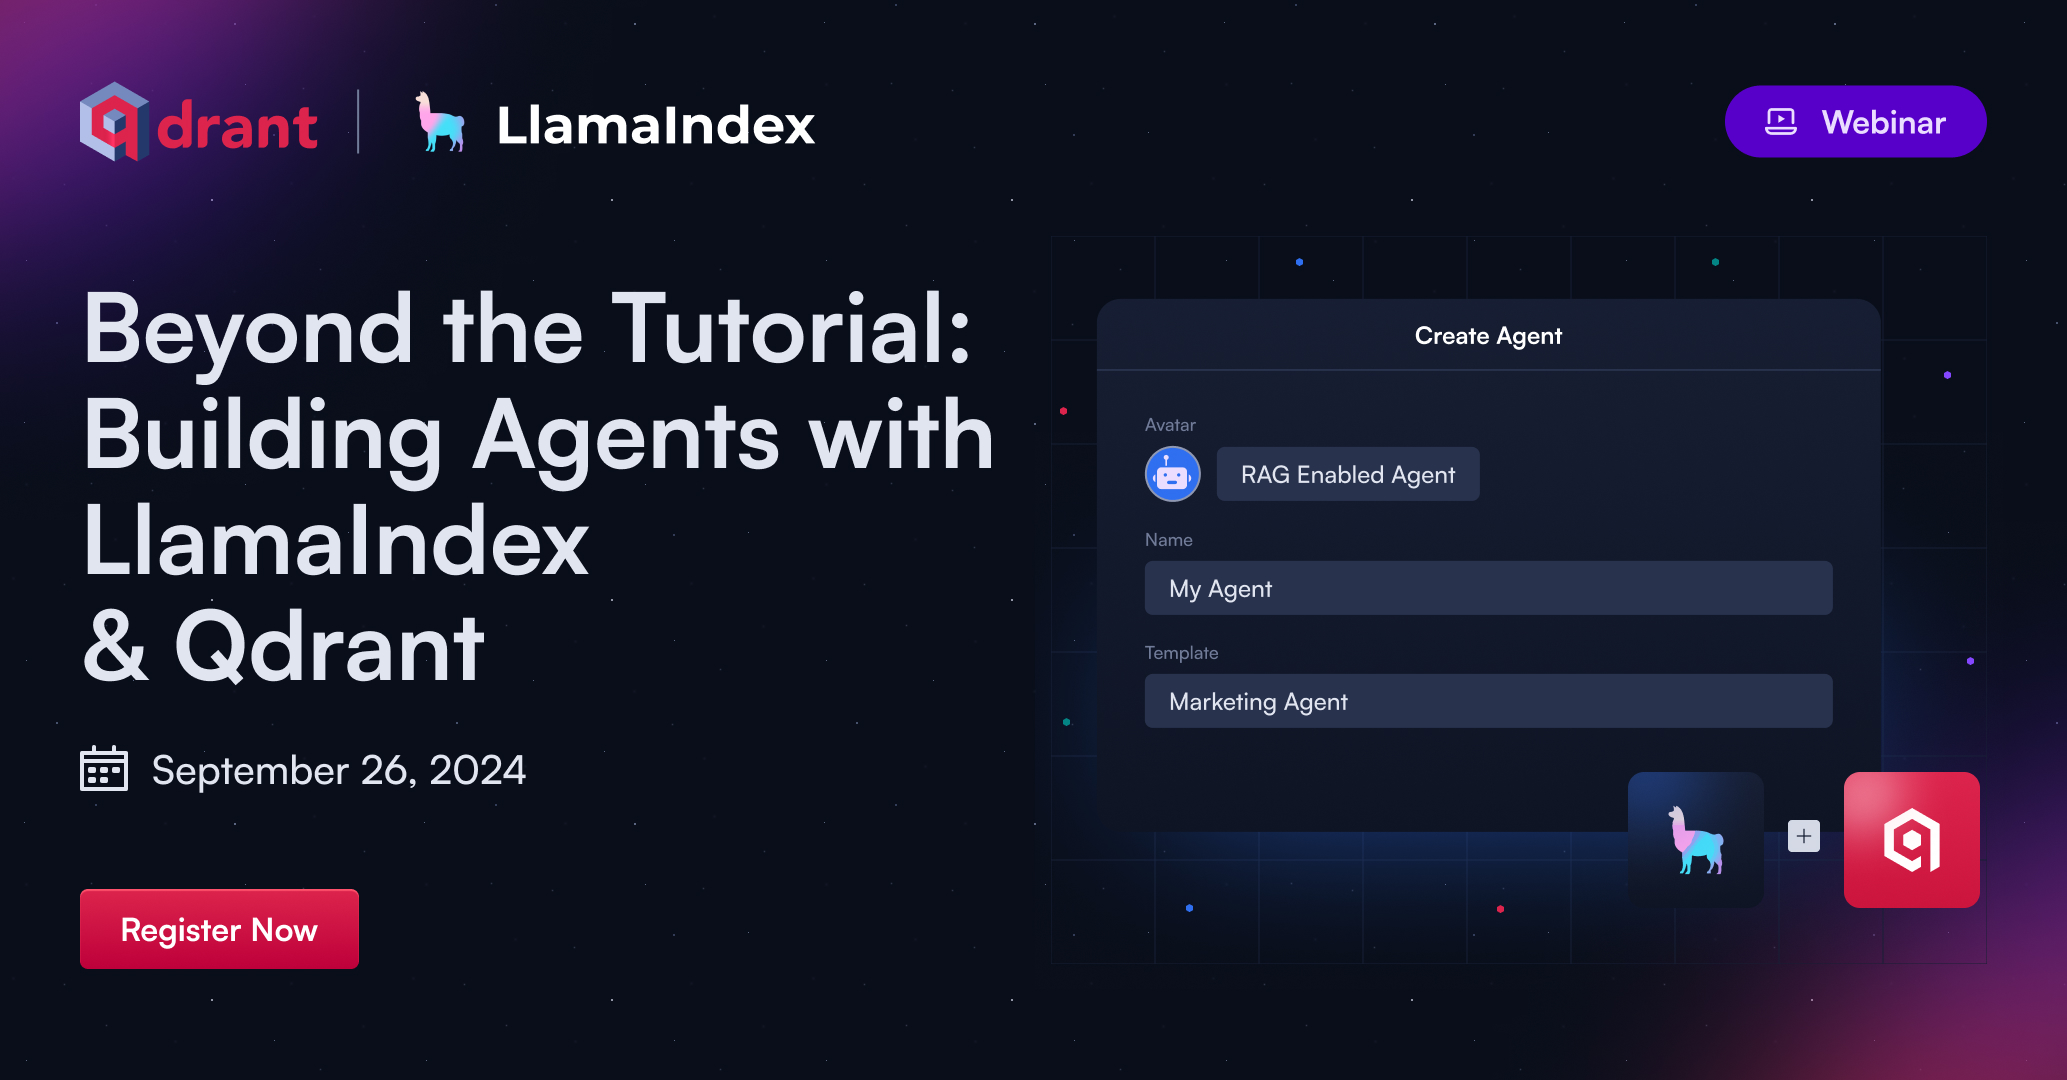

# Accelerating Agents with Semantic Caching using Qdrant & LlamaIndex

![Qdrant Logo](https://qdrant.tech/blog/hybrid-cloud-llamaindex/preview/title.jpg)

*With Qdrant and LlamaIndex you can save time and money with agents through semantic caching.*


## What you will learn today

1) Why are agents useful?

2) How to use Qdrant for semantic cache in an agentic system.

3) The benefits of semantic cache.


![Semantic Caching Workflow](
https://imgs.xkcd.com/comics/eagle.png)

## Agents



![Semantic Caching Workflow](https://platform.polygon.com/wp-content/uploads/sites/2/chorus/uploads/chorus_asset/file/23118910/agent_smith.jpg?quality=90&strip=all&crop=19.270015698587,0,61.459968602826,100) ![Semantic Caching Workflow](https://www.bankrate.com/2022/11/22154629/How-to-find-the-best-real-estate-agent-when-youre-ready-to-buy.jpg?auto=webp&optimize=high&crop=16:9) ![Semantic Caching Workflow](https://d26oc3sg82pgk3.cloudfront.net/files/media/edit/image/46729/article_aligned%402x.jpg) ![Semantic Caching Workflow](https://static.wikia.nocookie.net/hitman/images/9/97/47-woa.jpg/revision/latest?cb=20231222011840)







## Workflow Overview

![Semantic Caching Workflow](https://qdrant.tech/blog/semantic-cache-ai-data-retrieval/semantic-cache.gif)

*The diagram illustrates how the agent interacts with Qdrant to cache and retrieve responses.*


### Install packages


In [1]:
!pip install git+https://github.com/camel-ai/camel.git llama-index qdrant-client fastembed sentence-transformers

  Cloning https://github.com/camel-ai/camel.git to /tmp/pip-req-build-ge4aot3t
  Running command git clone --filter=blob:none --quiet https://github.com/camel-ai/camel.git /tmp/pip-req-build-ge4aot3t
  Resolved https://github.com/camel-ai/camel.git to commit e01356a7ffb0d39b551171f694840b184de34835
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import libraries


In [2]:
import os
from google.colab import userdata
from colorama import Fore

# Import necessary libraries
import time  # Import time module for timing
from camel.societies import RolePlaying
from camel.utils import print_text_animated
from qdrant_client import QdrantClient
from qdrant_client.http import models
from sentence_transformers import SentenceTransformer
import numpy as np
import uuid  # Import uuid module
#from llama_index.embeddings.fastembed import FastEmbedEmbedding



2024-09-26 16:21:26.693260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 16:21:26.741488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 16:21:26.754162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 16:21:26.810408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 16:21:30.274178: W tensorflow/compiler/tf2

### Set environment variables


In [3]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["QDRANT_API_KEY"] = userdata.get('QDRANT_API_KEY')
os.environ["QDRANT_URL"] = userdata.get('QDRANT_URL')

## Understanding Embeddings in Semantic Caching

![Embeddings Illustration](https://qdrant.tech/articles_data/what-are-embeddings/How-Do-Embeddings-Work_.jpg)

*Embeddings transform text into numerical vectors that capture semantic meaning.*


In [4]:
# Initialize the embedder
model_name = 'all-MiniLM-L6-v2'  # You can choose other models as needed
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Working with Qdrant

![Embeddings Illustration](https://pypi-camo.freetls.fastly.net/678e53a557ae6ec0e13046f8c38bf3f3f405905e/68747470733a2f2f6769746875622e636f6d2f716472616e742f716472616e742d636c69656e742f7261772f6d61737465722f646f63732f696d616765732f7472792d646576656c6f702d6465706c6f792e706e67)

*Embeddings transform text into numerical vectors that capture semantic meaning.*


In [5]:
# Initialize Qdrant client
qdrant_client = QdrantClient(":memory:")  # Use persistent storage in production
collection_name = "semantic_cache"

# Create a collection if it doesn't exist
try:
    qdrant_client.get_collection(collection_name=collection_name)
except Exception as e:
    qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE),
    )

In [6]:
def get_embedding(text):
    """Get the embedding of the text using Sentence Transformers."""
    embedding = embedder.encode([text])[0]
    return embedding

## Implementing Semantic Cache


In [7]:
def search_cache(prompt, threshold=0.85):
    """Search for a similar prompt in the cache."""
    embedding = get_embedding(prompt)
    search_result = qdrant_client.search(
        collection_name=collection_name,
        query_vector=embedding.tolist(),
        limit=1,
        with_payload=True,
        score_threshold=threshold,
    )
    if search_result:
        return search_result[0].payload['response']
    else:
        return None



In [8]:
def add_to_cache(prompt, response):
    """Add a new prompt and its response to the cache."""
    embedding = get_embedding(prompt)
    qdrant_client.upsert(
        collection_name=collection_name,
        points=[
            models.PointStruct(
                id=str(uuid.uuid4()),  # Generate a valid UUID
                vector=embedding.tolist(),
                payload={"prompt": prompt, "response": response},
            )
        ],
    )


## Agents with Camel AI

![Embeddings Illustration](https://repository-images.githubusercontent.com/615510678/93880a8f-edb6-4ef2-88d1-abff2651702e)


In [9]:
def process_prompt(task_prompt):
    """Process the task prompt, timing the execution."""
    start_time = time.time()
    print(Fore.YELLOW + f"Original task prompt:\n{task_prompt}\n")

    # Check the cache for a similar prompt
    cached_response = search_cache(task_prompt)

    if cached_response:
        print(Fore.GREEN + "Cache Hit: Retrieved response from cache.\n")
        print(Fore.GREEN + "Cached Response:\n\n" + cached_response + "\n")
    else:
        print(Fore.RED + "Cache Miss: No similar prompt found in cache.\n")
        print(Fore.BLUE + "Generating response using OpenAI...\n")

        # Proceed as usual if no cached response is found
        role_play_session = RolePlaying("Chef", "Nutrition Expert", task_prompt=task_prompt)
        print(Fore.CYAN + f"Specified task prompt:\n{role_play_session.task_prompt}\n")

        chat_turn_limit, n = 1, 0
        input_msg = role_play_session.init_chat()
        while n < chat_turn_limit:
            n += 1
            assistant_response, user_response = role_play_session.step(input_msg)
            print_text_animated(Fore.BLUE + f"AI User:\n\n{user_response.msg.content}\n")
            print_text_animated(Fore.GREEN + "AI Assistant:\n\n" f"{assistant_response.msg.content}\n")

            if "CAMEL_TASK_DONE" in user_response.msg.content:
                break

            input_msg = assistant_response.msg

        # Concatenate the conversation as the response
        response_text = f"AI User:\n{user_response.msg.content}\nAI Assistant:\n{assistant_response.msg.content}"

        # Add the prompt and response to the cache
        add_to_cache(task_prompt, response_text)
        print(Fore.GREEN + "Response has been added to the cache for future use.\n")

    # End timing
    end_time = time.time()
    execution_time = end_time - start_time

    print(Fore.MAGENTA + f"Total Execution Time: {execution_time:.2f} seconds\n")
    return execution_time

# Run the same prompt twice
task_prompt = "Give me a dinner menu focused around garlic"

print(Fore.BLUE + "First Run:\n")
first_run_time = process_prompt(task_prompt)

print(Fore.BLUE + "Second Run:\n")
second_run_time = process_prompt(task_prompt)

# Compare execution times
time_difference = first_run_time - second_run_time
print(Fore.CYAN + f"Time saved by using cache: {time_difference:.2f} seconds\n")

First Run:

Original task prompt:
Give me a dinner menu focused around garlic

Cache Miss: No similar prompt found in cache.

Generating response using OpenAI...

Specified task prompt:
Create a garlic-themed dinner menu featuring roasted garlic soup, garlic butter shrimp over linguine, garlic-infused roasted vegetables, and a garlic-herb focaccia. For dessert, serve a subtle garlic ice cream with a hint of vanilla. Pair with a crisp white wine to complement the flavors.

AI User:

Instruction: Create a recipe for roasted garlic soup.  
Input: Include ingredients and cooking instructions.


AI Assistant:

Solution: Here’s a detailed recipe for roasted garlic soup, perfect for your garlic-themed dinner menu.

**Ingredients:**
- 2 heads of garlic
- 2 tablespoons olive oil
- 1 medium onion, chopped
- 2 medium potatoes, peeled and diced
- 4 cups vegetable or chicken broth
- 1 cup heavy cream (optional for a creamier texture)
- Salt and pepper to taste
- Fresh thyme or parsley for garnish



## Visualizing the speed difference



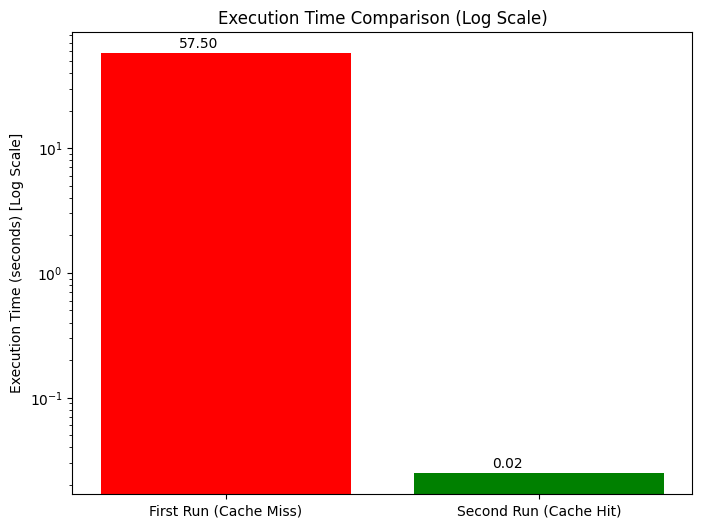

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have execution times
execution_times = [first_run_time, second_run_time]
labels = ['First Run (Cache Miss)', 'Second Run (Cache Hit)']

plt.figure(figsize=(8, 6))

# Use a logarithmic scale for the y-axis
bars = plt.bar(labels, execution_times, color=['red', 'green'])
plt.yscale('log')
plt.ylabel('Execution Time (seconds) [Log Scale]')
plt.title('Execution Time Comparison (Log Scale)')

# Add text labels on top of the bars with formatting
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.25, yval * 1.05, f"{yval:.2f}", va='bottom')  # Adjusting the position for log scale

plt.show()


## I wanna go fast!



### Speed

![Fast Car](
https://media.licdn.com/dms/image/C4D12AQHgd4_lby_fPA/article-cover_image-shrink_600_2000/0/1520221836371?e=2147483647&v=beta&t=QhS-D4ayzEGGvajx89ddEcvt5UDPfPmkjVDzkw8no80)

Retreival from the vector database happens much faster than the LLM can operate.